<a href="https://colab.research.google.com/github/ankitaggarwal64/Time-Series-Sales-Forecasting-for-Agricultural-Equipments/blob/main/Multivariate_Regression_with_ARIMA_errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**II. Regression with Seasonal ARIMA errors or SARIMAX:**

Regression with Seasonal ARIMA errors (also called Dynamic Regression) is able to learn from predictor variables as well as learn from the autocorrelation present in the response variable time series. Therefore we would like to use this model for incorporating the indices information along past sales history. 

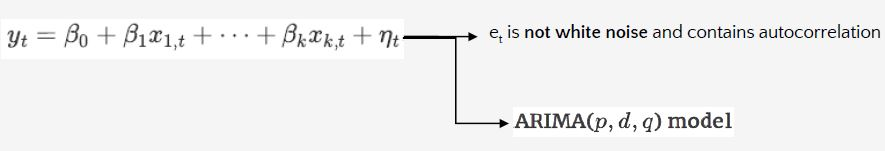

**Observations & Results Summary from ARIMAX modelling:**

*   SARIMAX_Test_Results : {'Test RMSE': 145.56, 'Test MAPE': 28.69, 'Testing Average Prediction Interval': 506.47}
*   Looking at the tracking signal charts, we can see that model has mix of underforecasting and overcasting periods which is good from cummulative forecast bias perspective for the company.







**Results Comparison  between ARIMA and ARIMAX**


ARIMA Test Results : {'Test RMSE': 125.36, 'Test MAPE': 25.22, 'Test Average Prediction Interval': 433.39}

SARIMAX Test Results : {'Test RMSE': 145.56, 'Test MAPE': 28.69, 'Test Average Prediction Interval': 506.47}

We can clearly see that ARIMA results are better than ARIMAX for every metric. However look at the tracking signals for these models we can clearly see that ARIMAX performed better than univariate ARIMA







**Future Scope of work:**


*   Until now we have experimented with ARIMA based Statistial models which are linear models and will not be able to learn non-linear paterns. Experimenting further with machine learning and deep learning models like LSTM can help with performance imporovement.
*   There are other well known methods such as Prophet method which can also be experimented to look for improvement posibilities.



In [ ]:
#Import libraries
import pandas as pd
from statsmodels.regression import linear_model
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import numpy as np
import warnings
import itertools
import statsmodels.api as sm
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#import data without predictors with significant missing values
data_selected = pd.read_csv("/content/drive/MyDrive/1. Data Science/Sales Forecasting_Masters Project/Masters Project/Data/Output_files/data_boruta_select.csv",parse_dates=['Time'], index_col='Time')

#Size of data - Sales and Indicesca
print(data_selected.shape)

# displaying data
display(data_selected)

(324, 6)


,Sales,corn1,hay2,ConstructionEm,wheat4,HOUST
Time,,,,,,
1990-01-31,505,239.83,93.3,5.42,3.71,1551.0
1990-02-28,467,241.59,95.2,5.42,3.56,1437.0
1990-03-31,467,250.58,96.7,5.39,3.48,1289.0
1990-04-30,593,273.49,103.0,5.36,3.49,1248.0
1990-05-31,866,284.34,104.0,5.32,3.40,1212.0
...,...,...,...,...,...,...
2016-08-31,102,323.04,138.0,6.70,3.67,1164.0
2016-09-30,200,328.90,137.0,6.73,3.49,1052.0
2016-10-31,611,349.49,135.0,6.74,3.68,1320.0


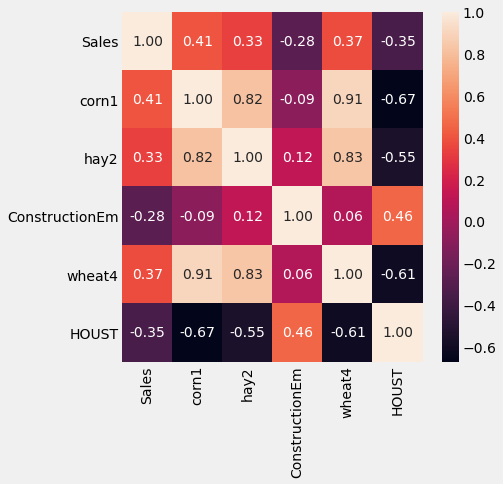

In [ ]:
# Plotting correlation heat map
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))  
sns.heatmap(data_selected.corr(),annot=True,fmt =".2f")

# corn1, hay2 and wheat4 are highly correlated. Further, we can explore VIF analysis to explore multicolinearity

In [ ]:
# Scale predictor variables between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = data_selected.iloc[:,1:]
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index = data_selected.index )

# Creating a dataframe with scaled variables
data_selected_scaled = pd.concat([data_selected.iloc[:,0], df_scaled], axis=1)
display(data_selected_scaled)

,Sales,corn1,hay2,ConstructionEm,wheat4,HOUST
Time,,,,,,
1990-01-31,505,0.098425,0.142949,0.268987,0.179952,0.597772
1990-02-28,467,0.101240,0.155128,0.268987,0.161836,0.534262
1990-03-31,467,0.115618,0.164744,0.259494,0.152174,0.451811
1990-04-30,593,0.152259,0.205128,0.250000,0.153382,0.428969
1990-05-31,866,0.169612,0.211538,0.237342,0.142512,0.408914
...,...,...,...,...,...,...
2016-08-31,102,0.231507,0.429487,0.674051,0.175121,0.382173
2016-09-30,200,0.240880,0.423077,0.683544,0.153382,0.319777
2016-10-31,611,0.273810,0.410256,0.686709,0.176329,0.469081


In [ ]:
# Calculating VIF values
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('Sales ~ corn1+hay2+ConstructionEm+wheat4+HOUST', data=data_selected_scaled, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
print(vif)



         VIF        variable
0  16.096285       Intercept
1   7.336780           corn1
2   3.852161            hay2
3   1.874270  ConstructionEm
4   7.234296          wheat4
5   2.820190           HOUST


Observations : 

1. All VIF values are less than 10, therefore all are considerable. 

2. Since corn1 and wheat4 has higher VIF value and we know both are highly correlated, therefore we can take average of both variables

In [ ]:
# Adding column with average of corn1 and wheat4
data_selected_scaled["Avg_corn1_wheat4"] = (data_selected_scaled["corn1"]+ data_selected_scaled["wheat4"])/2
display(data_selected_scaled.head())

,Sales,corn1,hay2,ConstructionEm,wheat4,HOUST,Avg_corn1_wheat4
Time,,,,,,,
1990-01-31,505,0.098425,0.142949,0.268987,0.179952,0.597772,0.139188
1990-02-28,467,0.101240,0.155128,0.268987,0.161836,0.534262,0.131538
1990-03-31,467,0.115618,0.164744,0.259494,0.152174,0.451811,0.133896
1990-04-30,593,0.152259,0.205128,0.250000,0.153382,0.428969,0.152820
1990-05-31,866,0.169612,0.211538,0.237342,0.142512,0.408914,0.156062


In [ ]:
# Calculating VIF values considering Avg_corn1_wheat4 index
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('Sales ~ hay2+ConstructionEm+HOUST+Avg_corn1_wheat4', data=data_selected_scaled, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
print(vif)
y

         VIF          variable
0  16.095953         Intercept
1   3.851185              hay2
2   1.699647    ConstructionEm
3   2.813668             HOUST
4   4.338315  Avg_corn1_wheat4


Observation: 

1.Now all VIF values are less than 5, therefore good for further modelling because of moderate multicolliniarity

In [ ]:
# Dropping corn1 and wheat4
data_selected_vif = data_selected_scaled.drop(["corn1","wheat4"],axis=1)
display(data_selected_vif.head())

,Sales,hay2,ConstructionEm,HOUST,Avg_corn1_wheat4
Time,,,,,
1990-01-31,505,0.142949,0.268987,0.597772,0.139188
1990-02-28,467,0.155128,0.268987,0.534262,0.131538
1990-03-31,467,0.164744,0.259494,0.451811,0.133896
1990-04-30,593,0.205128,0.250000,0.428969,0.152820
1990-05-31,866,0.211538,0.237342,0.408914,0.156062


**Train and Test Split:**

*   Train data : 1990 to 2012
*   Test data : 2013 to 2016 (4 Years)

In [ ]:
# Train and Test Split
split_point = len(data_selected_vif)-48 #Upto Dec-2012
df_train,df_test = data_selected_vif[0:split_point],data_selected_vif[split_point:]
print('Train %d, Test %d' % (len(df_train),len(df_test)))

Train 276, Test 48


**Create a Linear Regression model**

Experiment 1 : Considering all 4 predictors - hay2, ConstructionEm, HOUST, Avg_corn1_wheat4

In [ ]:
#Create the model expression : 
expr = 'Sales ~ hay2+ConstructionEm+HOUST+Avg_corn1_wheat4'

#Carve out the y and X matrices
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

#Fit an OLSR model on the training dataset:
olsr_results1 = linear_model.OLS(y_train, X_train).fit()

#OLSR model’s training results:
print(olsr_results1.summary())
print("AIC:",olsr_results1.aic)

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     21.36
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           2.50e-15
Time:                        18:11:18   Log-Likelihood:                -1841.5
No. Observations:                 276   AIC:                             3693.
Df Residuals:                     271   BIC:                             3711.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          413.5072     44.667  

Observation from Experiment 1: 

*  Since values of Durbin Watson (DW) statistic is between 0 and 2 which indicates positive autocorrelation between residuals. Therefore we can model residual with ARIMA modeling.
*   With low prob(F-Statistic). it is clear there is aleast one useful predictor variable
*   Not a very large number of Condition Number represents there is not a significant multicollinearity





Experiment 2 : Considering 3 predictors - hay2, ConstructionEm, Avg_corn1_wheat4 (removing HOUST variable)

In [ ]:
#Create the model expression : 
expr2 = 'Sales ~ hay2+ConstructionEm+ Avg_corn1_wheat4'

#Carve out the y and X matrices
y_train2, X_train2 = dmatrices(expr2, df_train, return_type='dataframe')
y_test2, X_test2 = dmatrices(expr2, df_test, return_type='dataframe')

#Fit an OLSR model on the training dataset:
olsr_results2 = linear_model.OLS(y_train2, X_train2).fit()

#OLSR model’s training results:
print("AIC:",olsr_results2.aic)

AIC: 3691.6685713021366


Experiment 3 : Considering 2 predictors - hay2, ConstructionEm (removing HOUST and Avg_corn1_wheat4)

In [ ]:
#Create the model expression : 
expr3 = 'Sales ~ hay2+ConstructionEm'

#Carve out the y and X matrices
y_train3, X_train3 = dmatrices(expr3, df_train, return_type='dataframe')
y_test3, X_test3 = dmatrices(expr3, df_test, return_type='dataframe')

#Fit an OLSR model on the training dataset:
olsr_results3 = linear_model.OLS(y_train3, X_train3).fit()

#OLSR model’s training results:
print("AIC:",olsr_results3.aic)

AIC: 3690.4036289068144


Based on Experiments 1,2,3 : We observed that there is not a significant improvement in AIC values even after removing  HOUST and Avg_corn1_wheat4. Also, we would like to keep information from all  4 varaibles. Therefore we will keep all the 4 variables for further analysis

**ARIMA modelling on the OLSR model’s residual errors of regression**

Estimate (S)ARIMA parameters (p,d,q), (P,D,Q) and m :

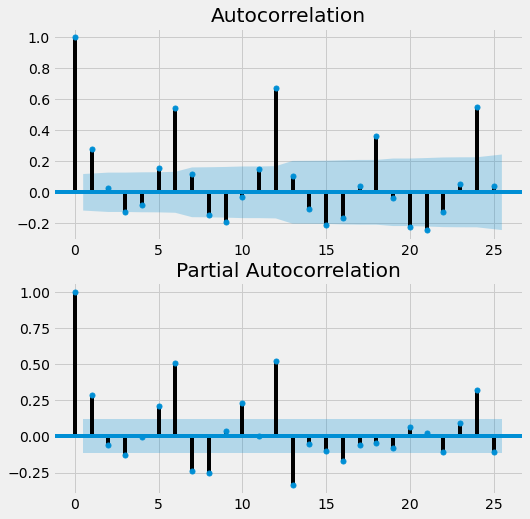

In [ ]:
#Plot ACF and PACF
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import pylab

train_r = olsr_results1.resid
pylab.rcParams['figure.figsize'] = (7.5,8)
pyplot.figure()
pyplot.subplot(211)
plot_acf(train_r, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(train_r, lags=25, ax=pyplot.gca())
pyplot.show()
#OBSERVATIONS:
#There is a clear seasonality of 12 as seen in the peaks of ACF plot
#There is a possibility of both AR and MA terms because of geometric decay on ACF plot and significant autocorrelation of particular lags on PACF plot

In [ ]:
# Define the p, d and q parameters possible values
p = range(0, 2)
d = range(0, 3)
q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (0, 2, 0, 12)


In [ ]:
# specify to ignore warning messages
warnings.filterwarnings("ignore") 

# Grid Cross validation for best parameters estimation
columns = ['param','param_seasonal','aic']
rows = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_r,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            row = [param, param_seasonal, results.aic]
            rows.append(row)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

models_aic = pd.DataFrame(rows, columns=columns)

In [ ]:
# Sorting the Model results 
models_aic.sort_values(by=["aic"])

,param,param_seasonal,aic
119,"(1, 1, 1)","(1, 2, 1, 12)",2920.492412
47,"(0, 1, 1)","(1, 2, 1, 12)",2925.243836
95,"(1, 0, 1)","(1, 2, 1, 12)",2926.762546
143,"(1, 2, 1)","(1, 2, 1, 12)",2940.294727
83,"(1, 0, 0)","(1, 2, 1, 12)",2947.638060
...,...,...,...
96,"(1, 1, 0)","(0, 0, 0, 12)",3731.254572
60,"(0, 2, 1)","(0, 0, 0, 12)",3739.853065
24,"(0, 1, 0)","(0, 0, 0, 12)",3758.964913
120,"(1, 2, 0)","(0, 0, 0, 12)",3893.617583


In [ ]:
#Intantiate the model with best Model Paramter
mod = sm.tsa.statespace.SARIMAX(train_r,
                                order=(1, 1, 1),
                                seasonal_order=(1, 2, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit training
results = mod.fit()

In [ ]:
# Model Summary Statistics
print(results.summary())

# Obseration : High probability of Ljung-Box repesents lack of autocorrelation

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  276
Model:             SARIMAX(1, 1, 1)x(1, 2, 1, 12)   Log Likelihood               -1455.246
Date:                            Tue, 08 Dec 2020   AIC                           2920.492
Time:                                    18:12:25   BIC                           2937.833
Sample:                                01-31-1990   HQIC                          2927.482
                                     - 12-31-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2817      0.093      3.013      0.003       0.098       0.465
ma.L1         -1.3146      0.118   

In [ ]:
# Checking Residual Summary Statistics
results.resid.describe()

# Obseration : Residual mean is not very far from zero.

count    276.000000
mean      -5.969763
std      143.698838
min     -510.172140
25%      -76.006709
50%       -9.470580
75%       67.726270
max      719.863713
dtype: float64

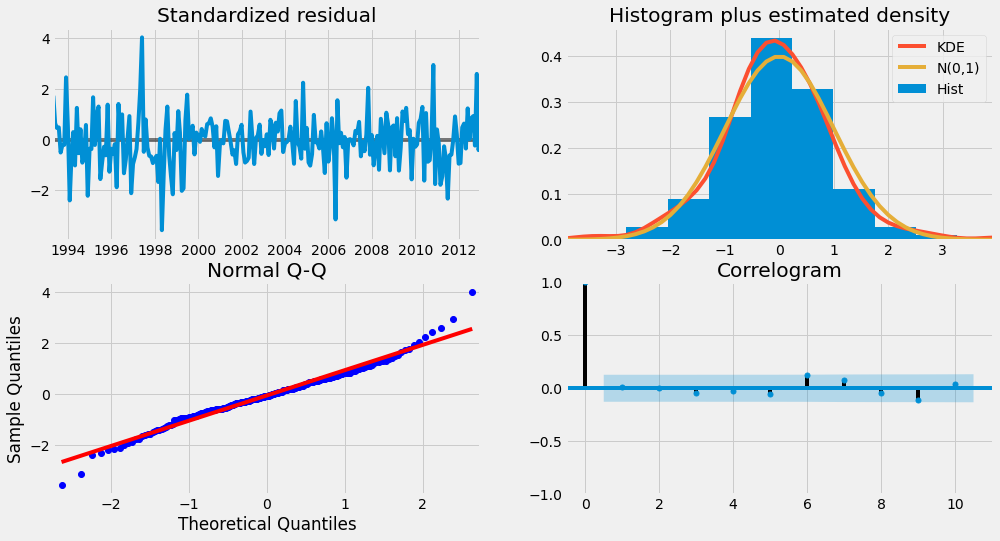

In [ ]:
# Residual diagnostics
results.plot_diagnostics(figsize=(15, 8))
plt.show()

# Obervation: Based on plots, residuals seems to be close to white noise, normally distributed and does not seems to have any significant autocorrelation

Estimate of (p,d,q) x (P,D,Q,m)   : Based on above ARIMA analysis on regression residuals, We can use order (1, 1, 1)x(1, 2, 1, 12) for Regression Modelling with Regression Errors

**Build and fit the Regression Model with Seasonal ARIMA errors**

In [ ]:
#Create the model expression : 
expr = 'Sales ~ hay2+ConstructionEm+HOUST+Avg_corn1_wheat4'

#Carve out the y and X matrices
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [ ]:
# Removing intercept from X_train
X_train_minus_intercept = X_train.drop('Intercept', axis=1)
display(X_train_minus_intercept.head())

,hay2,ConstructionEm,HOUST,Avg_corn1_wheat4
Time,,,,
1990-01-31,0.142949,0.268987,0.597772,0.139188
1990-02-28,0.155128,0.268987,0.534262,0.131538
1990-03-31,0.164744,0.259494,0.451811,0.133896
1990-04-30,0.205128,0.250000,0.428969,0.152820
1990-05-31,0.211538,0.237342,0.408914,0.156062


In [ ]:
#Intantiate the model with best Model Paramter
sarimax_model = sm.tsa.statespace.SARIMAX(endog=y_train, exog=X_train_minus_intercept,order=(1,1,1), seasonal_order=(1,2,1,12),enforce_stationarity=False,enforce_invertibility=False)

# Fit training
sarimax_results = sarimax_model.fit()


In [ ]:
# Model Summary Statistics
print(sarimax_results.summary())

# Obseration : High probability of Ljung-Box repesents lack of autocorrelation 

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  276
Model:             SARIMAX(1, 1, 1)x(1, 2, 1, 12)   Log Likelihood               -1457.329
Date:                            Tue, 08 Dec 2020   AIC                           2932.659
Time:                                    18:13:39   BIC                           2963.871
Sample:                                01-31-1990   HQIC                          2945.239
                                     - 12-31-2012                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
hay2                13.8675    179.293      0.077      0.938    -337.541     365.276
ConstructionEm   

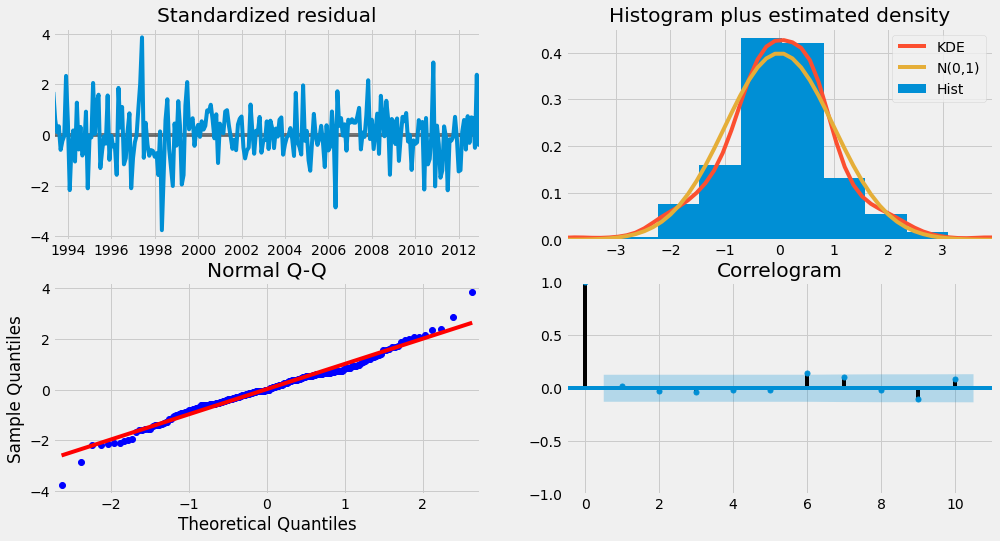

In [ ]:
# Residual diagnostics
sarimax_results.plot_diagnostics(figsize=(15, 8))
plt.show()

# Obervation: Based on plots, residuls seems to be close to white noise, normally distributed and does not seems to have any significant autocorrelation

In [ ]:
#Residual Standard deviation
print("Residual Standard Deviation : ",sarimax_results.resid.describe()["std"])

Residual Standard Deviation :  145.20660945084498


**Walk Forward Validation:**

In [ ]:
# Walk Forward validation
min_train_len = len(train)-6*12-1 # upto Nov-2006
forcast_horizon = 2 # Two months advance forecast is considere

In [ ]:
# Creating list to store model validation metrics during walk forward validation
columns_val = ["Index","Observed", "Forecast(mean)","Upper_forecast","Lower_forecast","Length_Predicion_Interval","MAD",'Bias',"Tracking_Signal"]
rows_val = []
Sum_forecast_error = 0
Sum_abs_forecast_error = 0
MAD = 0

In [ ]:
# Calculating evaluation metrics during walk forward validation
for i in range(0,(6*12)):
  start= min_train_len+i # index for start of prediction
  end = min_train_len+i+(forcast_horizon-1) # Index for end of prediction
  
  pred_dynamic = sarimax_results.get_prediction(start= start, end = end , dynamic=True)
  pred_dynamic_ci = pred_dynamic.conf_int()

  # Extract the predicted and true values of our time series
  y_val_forecasted = pred_dynamic.predicted_mean[forcast_horizon-1]
  y_val_truth = train[end]

  # Length of Prediction Interval(95% CI)
  Upper_forecast =pred_dynamic_ci.iloc[forcast_horizon-1,:]["upper Sales"]
  Lower_forecast =pred_dynamic_ci.iloc[forcast_horizon-1,:]["lower Sales"]
  len_prediction_interval = Upper_forecast - Lower_forecast

  # Forecast Error
  forecast_error = y_val_truth - y_val_forecasted

  # Absolute Forecast Error
  abs_forecast_error = abs(y_val_truth - y_val_forecasted)

  # Compute Commulative forecast error 
  Sum_forecast_error = Sum_forecast_error + forecast_error

  # Compute Commulative Absolute Forecast Error
  Sum_abs_forecast_error = Sum_abs_forecast_error + abs_forecast_error

  # Mean Absolute Deviation
  MAD = Sum_abs_forecast_error/(i+1)

  # Bias
  Bias = Sum_forecast_error/(i+1)

  # Tracking Signal
  Tracking_signal = Sum_forecast_error/MAD

  row = [train[[end]].index.date[0] ,y_val_truth,y_val_forecasted, Upper_forecast,Lower_forecast,len_prediction_interval,MAD, Bias,Tracking_signal]
  rows_val.append(row)

In [ ]:
# Validation Error & Metrics from 2007 to 2012 with forecast horizon of 2 months
val_metrics = pd.DataFrame(rows_val, columns=columns_val)
val_metrics = val_metrics.set_index('Index')
display(val_metrics)

,Observed,Forecast(mean),Upper_forecast,Lower_forecast,Length_Predicion_Interval,MAD,Bias,Tracking_Signal
Index,,,,,,,,
2007-01-31,230,131.319889,378.111783,-115.472005,493.583788,98.680111,98.680111,1.000000
2007-02-28,188,95.579590,342.198942,-151.039763,493.238705,95.550261,95.550261,2.000000
2007-03-31,449,365.269714,611.686752,118.852677,492.834076,91.610269,91.610269,3.000000
2007-04-30,678,568.765968,815.120153,322.411782,492.708371,96.016210,96.016210,4.000000
2007-05-31,394,231.640980,477.974304,-14.692345,492.666649,109.284772,109.284772,5.000000
...,...,...,...,...,...,...,...,...
2012-08-31,583,467.581529,712.022343,223.140715,488.881628,91.062320,4.118363,3.075352
2012-09-30,774,788.123410,1032.564006,543.682814,488.881192,89.947263,3.853990,2.956458
2012-10-31,1498,1269.278571,1513.719160,1024.837981,488.881180,91.929751,7.066382,5.380703


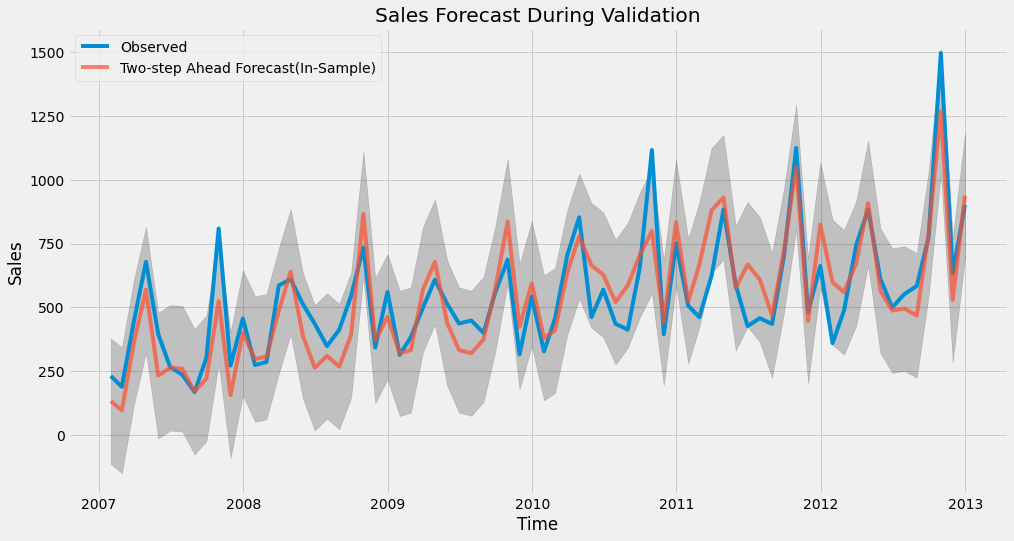

In [ ]:
# Plotting Sales v/s Time forecast
ax = val_metrics["Observed"].plot(label='Observed',figsize=(15, 8))
val_metrics["Forecast(mean)"].plot(ax=ax, label='Two-step Ahead Forecast(In-Sample)', alpha=.7)
ax.fill_between(val_metrics.index,val_metrics.iloc[:,3],val_metrics.iloc[:,2], color='k', alpha=.2)
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
plt.title("Sales Forecast During Validation")
plt.legend()
plt.show()

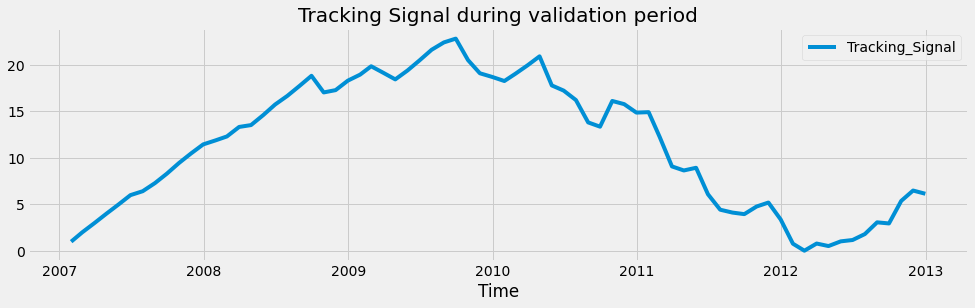

In [ ]:
#Plotting Tracking Signal
ax = val_metrics["Tracking_Signal"].plot(figsize=(15,4))
plt.title("Tracking Signal during validation period")
ax.set_xlabel('Time')
plt.legend()
plt.show()

# Observation: Since our tracking signal is continuosly above 4.5 most of the time, we can say that our model is underforecasting most of the time.

In [ ]:
# Calculating evaluation metrics during validation

# Compute the Root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(val_metrics["Observed"], val_metrics["Forecast(mean)"]))

# Calculating MAPE during validation
percent_forecast_errors = abs(val_metrics["Observed"] - val_metrics["Forecast(mean)"])*100/val_metrics["Observed"] 
MAPE = sum(percent_forecast_errors)*1.0/len(percent_forecast_errors)

# Prediction Interval
Prediction_interval = val_metrics["Length_Predicion_Interval"].mean()

# Storing Results in Dictionary
SARIMAx_Val_Results = {"Validation RMSE":round(rmse,2),"Validation MAPE":round(MAPE,2),"Validation Average Prediction Interval":round(Prediction_interval,2)} 
print(SARIMAx_Val_Results)

{'Validation RMSE': 116.15, 'Validation MAPE': 18.43, 'Validation Average Prediction Interval': 490.74}


**Model Testing with Batch Training**

In [ ]:
# Walk Forward Model testing
min_train_len = len(train)-1 # upto Nov-2012
forcast_horizon = 2 # Two months advance forecast are considered as most of supply chain is confirmed two months in advance of the sales month

In [ ]:
# Creating list to store model test metrics during walk forward validation
columns_test = ["Index","Observed", "Forecast(mean)","Upper_forecast","Lower_forecast","Length_Predicion_Interval","MAD",'Bias',"Tracking_Signal"]
rows_test = []
Sum_forcast_error = 0
Sum_abs_forecast_error = 0
MAD = 0

In [ ]:
# Getting complete Sales and Predictor variables history
Sales = data_selected_vif.iloc[:,0]
Predictors = data_selected_vif.iloc[:,1:]
test = df_test["Sales"]

In [ ]:
# Calculating evaluation metrics during walk forward testing
for i in range(0,4*12):
  start= min_train_len+i 
  end = min_train_len+i+(forcast_horizon-1)

  # specify to ignore warning messages
  warnings.filterwarnings("ignore") 

 #Intantiate the model (with Batch Training)
  sarimax_model = sm.tsa.statespace.SARIMAX(endog=Sales[:start], exog=Predictors[:start],order=(1,1,1), seasonal_order=(1,2,1,12),enforce_stationarity=False,enforce_invertibility=False)

  # Fit training
  results = sarimax_model.fit()

  # Get forecast for forecast horizon of 2 months
  pred_dynamic = results.get_forecast(steps=2,exog=Predictors[start:start+2])

  # Get confidence intervals of forecasts
  pred_dynamic_ci = pred_dynamic.conf_int()

  # Length of Prediction Interval(95% CI)
  Upper_forecast =pred_dynamic_ci.iloc[forcast_horizon-1,:]["upper Sales"]
  Lower_forecast =pred_dynamic_ci.iloc[forcast_horizon-1,:]["lower Sales"]
  len_prediction_interval = Upper_forecast - Lower_forecast

  y_val_forecasted = pred_dynamic.predicted_mean[forcast_horizon-1]
  y_val_truth = test[i]

  # Forecast Error
  forecast_error = y_val_truth - y_val_forecasted

  # Absolute Forecast Error
  abs_forecast_error = abs(y_val_truth - y_val_forecasted)

  # Compute Commulative forecast error 
  Sum_forecast_error = Sum_forecast_error + forecast_error
  print("Sum_forecast_error",Sum_forecast_error)

  # Compute Commulative Absolute Forecast Error
  Sum_abs_forecast_error = Sum_abs_forecast_error + abs_forecast_error

  # Mean Absolute Deviation
  MAD = Sum_abs_forecast_error/(i+1)
  print("MAD",MAD)

  # Bias
  Bias = Sum_forecast_error/(i+1)

  # Tracking Signal
  Tracking_signal = Sum_forecast_error/MAD
  print("Tracking_signal",Tracking_signal)

  row = [test[[i]].index.date[0] ,y_val_truth,y_val_forecasted, Upper_forecast,Lower_forecast,len_prediction_interval,MAD, Bias,Tracking_signal]
  rows_test.append(row)


In [ ]:
# Test Error & Metrics from 2013 to 2016 with forecast horizon of 2 months
test_metrics = pd.DataFrame(rows_test, columns=columns_test)
test_metrics = test_metrics.set_index('Index')
display(test_metrics.head())

,Observed,Forecast(mean),Upper_forecast,Lower_forecast,Length_Predicion_Interval,MAD,Bias,Tracking_Signal
Index,,,,,,,,
2013-01-31,678,626.718616,880.559306,372.877926,507.681380,51.281384,612.642466,11.946683
2013-02-28,669,707.363440,951.923152,462.803728,489.119424,44.822412,287.139513,12.812319
2013-03-31,702,964.479354,1207.819293,721.139415,486.679878,117.374726,103.933224,2.656446
2013-04-30,851,1045.824713,1296.011654,795.637772,500.373882,136.737223,29.243740,0.855473
2013-05-31,554,681.080058,933.753680,428.406436,505.347244,134.805790,-2.021020,-0.074960


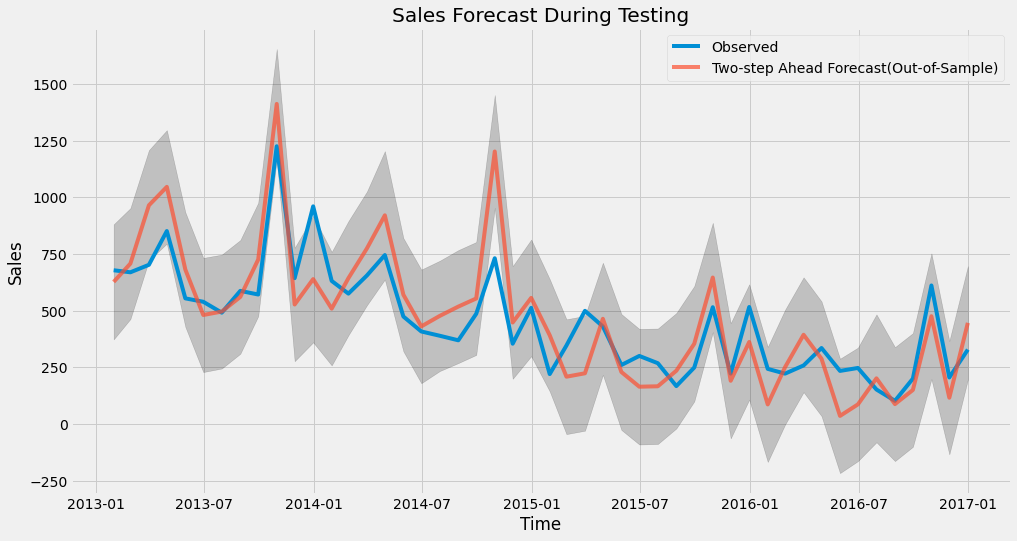

In [ ]:
# Plotting Sales v/s Time forecast during test period
ax = test_metrics["Observed"].plot(label='Observed',figsize=(15, 8))
test_metrics["Forecast(mean)"].plot(ax=ax, label='Two-step Ahead Forecast(Out-of-Sample)', alpha=.7)
ax.fill_between(test_metrics.index,test_metrics.iloc[:,3],test_metrics.iloc[:,2], color='k', alpha=.2)
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
plt.title("Sales Forecast During Testing")
plt.legend()

plt.show()

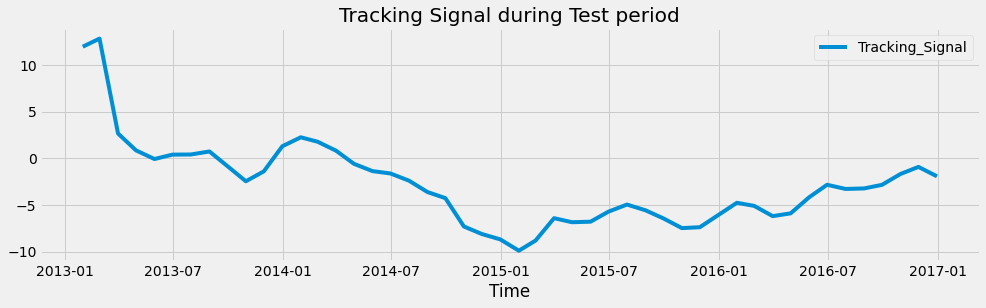

In [ ]:
#Plotting Tracking Signal
ax = test_metrics["Tracking_Signal"].plot(figsize=(15,4))
plt.title("Tracking Signal during Test period")
ax.set_xlabel('Time')
plt.legend()
plt.show()

# Observation: Because of the changing values of tracking signal in positive and negative direction, we see that our model not showing a continuos underforecasting or overforecasting.

In [ ]:
#Test Metrics

# Compute the Root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test_metrics["Observed"], test_metrics["Forecast(mean)"]))

# Calculating MAPE during validation
percent_forecast_errors = abs(test_metrics["Observed"] - test_metrics["Forecast(mean)"])*100/test_metrics["Observed"] 
MAPE = sum(percent_forecast_errors)*1.0/len(percent_forecast_errors)

# Prediction Interval
Prediction_interval = test_metrics["Length_Predicion_Interval"].mean()

# Storing Results in Dictionary
SARIMAx_Test_Results = {"Test RMSE":round(rmse,2),"Test MAPE":round(MAPE,2),"Testing Average Prediction Interval":round(Prediction_interval,2)} 
print(SARIMAx_Test_Results)

{'Test RMSE': 145.56, 'Test MAPE': 28.69, 'Testing Average Prediction Interval': 506.47}


Results Comparison :

ARIMA Test Results : {'Test RMSE': 125.36, 'Test MAPE': 25.22, 'Test Average Prediction Interval': 433.39}

SARIMAX_Test_Results : {'Test RMSE': 145.56, 'Test MAPE': 28.69, 'Testing Average Prediction Interval': 506.47}


References:


1.   https://towardsdatascience.com/regression-with-arima-errors-3fc06f383d73
2. https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html?highlight=arimax#statsmodels.tsa.statespace.sarimax.SARIMAX